# A/B Testing Data Challenge


Suppose you are a Data Scientist on the Mobile team at a Q&A platform company. The team has just introduced a new UI design to the app. The goal of the new design is to increase user engagement (measured by minutes spent on site). The team ran an A/B test to evaluate the change. Using the data, help the team understand the impact of the UI change better.

Tables provided are as follows:
    1. t1_user_active_min.csv
    2. t2_user_variant.csv
    3. t3_user_active_min_pre.csv
    4. t4_user_attributes.csv
    
**In order to measure the experiment effect on user engagement, let's say you want to perform a t-test of the difference in minutes spent on site. What would be your unit of analysis (i.e. when conducting a t-test, we calculate means and variances of two samples. What does each data point represent in the samples?)?**

> <font color=	#000066> The unit of analysis should be **total minutes per user**. It cannot be minutes per user per day, because we would have correlated data points in the sample (i.e. minutes spent on the site by a given user on different days are not independent), while the t-test assumes independent data. Obviously, the unit of analysis cannot be minutes per group because that would only yield one data point per sample.  </font> 

***

**Using t-test under your assumption about variance, find an appropriate 95% confidence interval of the overall average treatment effect (i.e. difference in TOTAL active minutes between test and control, during the entire duration of the experiment). Based on your findings, what is your recommended course of action regarding the new UI design?** 

<font color= #000066>
    
>  The confidence interval for the overall average treatment effect is **[-38.00, 38.42]** suggesting the treatment effect is very non-significant (p-value of 0.99). However, we must interpret this result carefully, since the distribution of the total active minutes per user is non-Gaussian, peaked at 0 and with extremely long tails. Since the t-test assumes normally distributed data, it may not yield the most accurate results in this case.
>
>  Mathematically, it would be much better to take the log of the total active minutes, in order to make the distribution more Gaussian before applying a t-test. Interestingly, doing so shows that the effect of the treatment is highly significant (p-value < 0.001)! To make sense of this apparent contradiction, we plot the two distributions before and after applying the log transformation. In both cases we can see that the difference between the control and treatment distributions is concentrated at small values. The log-transformation increases the relative importance of the small values, which explains why the treatment effect can become significant in log-space. 
>
>  While applying a log-transformation **is** the correct thing to do mathematically, in terms of answering the original business question it does not help very much, since we actually care about effect size in normal minutes, not in log minutes. In the end, based on this analysis, I recommemded not pushing to production, as well as conducting further research. 


***

In [375]:
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

In [376]:
url = 'https://raw.githubusercontent.com/edvinmemet/projects/master/data/ab_testing/t1_user_active_min.csv?token=AF52KYPFHKB2BYP3BVSEVU25UUMJU'
df_exp = pd.read_csv(url)
df_exp[['active_mins']].describe()

,active_mins
count,1.066402e+06
mean,3.616809e+01
std,1.270484e+03
min,1.000000e+00
25%,2.000000e+00
50%,5.000000e+00
75%,1.700000e+01
max,9.999900e+04


In [377]:
df_exp = df_exp[df_exp['active_mins'] < max(df_exp['active_mins'])]  #remove outliers 
df_exp[['active_mins']].sort_values(by = 'active_mins').tail(100) #check tail of distribution

,active_mins
167892,830.0
684813,831.0
319205,831.0
1011884,832.0
954560,832.0
...,...
53131,894.0
793665,894.0
925607,895.0
495393,896.0


In [378]:
url = 'https://raw.githubusercontent.com/edvinmemet/projects/master/data/ab_testing/t2_user_variant.csv?token=AF52KYIRBSWWK57OEQU4V625UUM5Y'
df_variant = pd.read_csv(url)
df_exp = pd.merge(df_exp, df_variant.drop('dt', axis=1), on = 'uid', how='left') #merge tables 1 and 2
df_exp["dt"] = df_exp["dt"].astype("datetime64")
df_exp["signup_date"] = df_exp["signup_date"].astype("datetime64")

exp_start_date = min(df_exp.dt)

In [379]:
df_exp_ctrl =  df_exp[df_exp.variant_number == 0] #create dataframe for the control group
df_exp_treat = df_exp[df_exp.variant_number == 1] #create dataframe for the treatment group

exp_ctrl = df_exp_ctrl.groupby(['uid'])['active_mins'].sum() #total minutes for users in control group
exp_treat = df_exp_treat.groupby(['uid'])['active_mins'].sum() #total minutes for users in treatment group

# interestingly, people in control group visit more the site frequently than those in treatment group
print('Average number of visits during experiment period: control= ' + str(round(df_exp_ctrl.uid.value_counts().mean())) + ', treatment= ' +str(round(df_exp_treat.uid.value_counts().mean())))

Average number of visits during experiment period: control= 24, treatment= 19


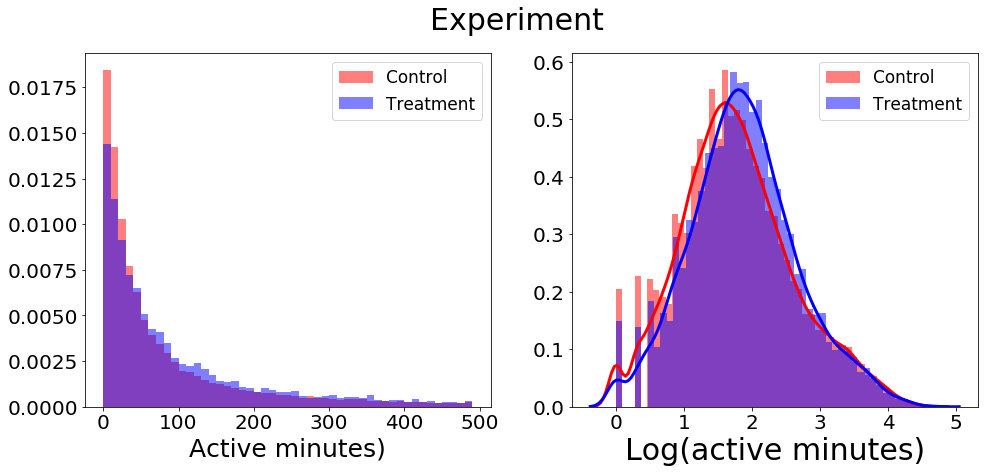

In [380]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 6.5)

sns.distplot(exp_ctrl, bins = np.arange(0, 500, 10), norm_hist=True, kde = False, hist_kws={"alpha": 0.5, "color": "r"}, label= "Control", ax = ax[0])
sns.distplot(exp_treat, bins = np.arange(0, 500, 10), norm_hist=True, kde = False, hist_kws={"alpha": 0.5, "color": "b"}, label= "Treatment", ax = ax[0])

sns.distplot(np.log10(exp_ctrl), hist=True, kde=True, kde_kws={"color": "r", "lw": 3}, hist_kws={"alpha": 0.5, "color": "r"}, label= "Control", ax = ax[1])
sns.distplot(np.log10(exp_treat), hist=True, kde=True, kde_kws={"color": "b", "lw": 3}, hist_kws={"alpha": 0.5, "color": "b"}, label= "Treatment", ax = ax[1])

fig.suptitle('Experiment', fontsize = 30)
ax[0].set_xlabel("Active minutes)",fontsize=25), ax[1].set_xlabel("Log(active minutes)",fontsize=30)
ax[0].tick_params(labelsize=20), ax[1].tick_params(labelsize=20)
ax[0].legend(fontsize='17'), ax[1].legend(fontsize='17');

In [381]:
welch_t_test = sms.CompareMeans.from_data(exp_treat, exp_ctrl)
print(welch_t_test.summary(usevar='unequal'))

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      0.1813     19.488      0.009      0.993     -38.017      38.380


**You decide to dive deeper into the data, so you gather a table of active minutes by user from before the experiment began. You should now use table 3 (t3_user_active_min_pre.csv) along with tables 1 and 2 for this question. How does the treatment effect trend over time? Using the statistical method of your choice and the new data, update your 95% confidence interval of the overall average treatment effect (difference in TOTAL active minutes). What method do you use to compute your updated treatment effect?**

<font color= #000066>
    
>  Using the pre-experiment data, we find that the control and treatment groups are substantially different from before the experiment started. To compute the treatment effect in light of this new data, we apply a t-test to the **change** in total minutes as a result of the experiment for the two treatment variants. To do so, we restrict our analysis to users present in both the pre-experiment and experiment periods and we restrict the duration of the pre-experiment period to the same length as the experiment period (149 days). This is a good way to clean up the data, since it also takes care of other issues, such as users signing up during the pre-experiment period or dropping out before the experiment end. 

***




In [382]:
url = 'https://raw.githubusercontent.com/edvinmemet/projects/master/data/ab_testing/t3_user_active_min_pre.csv?token=AF52KYIBHTZNCXN7X4RFGWC5UUNAE'
df_pre = pd.read_csv(url)
df_pre[['active_mins']].describe()

,active_mins
count,1.190093e+06
mean,3.220315e+01
std,1.181531e+03
min,1.000000e+00
25%,2.000000e+00
50%,4.000000e+00
75%,1.400000e+01
max,9.999900e+04


In [383]:
df_pre = df_pre[df_pre['active_mins'] < max(df_pre['active_mins'])] #remove outliers 
df_exp[['active_mins']].sort_values(by = 'active_mins').tail(100) #check tail of distribution

,active_mins
167884,830.0
684705,831.0
319166,831.0
1011728,832.0
954407,832.0
...,...
53129,894.0
793548,894.0
925464,895.0
495310,896.0


In [384]:
df_pre = pd.merge(df_pre, df_variant.drop('dt', axis=1), on = 'uid', how='left') #merge tables 2+3
df_pre["signup_date"] = df_pre["signup_date"].astype("datetime64")
df_pre["dt"] = df_pre["dt"].astype("datetime64")

pre_start_date = min(df_pre.dt)

In [385]:
df_pre_ctrl =  df_pre[df_pre.variant_number == 0] #create dataframe for the control group
df_pre_treat = df_pre[df_pre.variant_number == 1] #create dataframe for the treatment group

pre_ctrl = df_pre_ctrl.groupby(['uid'])['active_mins'].sum() #total minutes for users in ctrl
pre_treat = df_pre_treat.groupby(['uid'])['active_mins'].sum() #total minutes for users in treat

welch_t_test = sms.CompareMeans.from_data(pre_treat, pre_ctrl)
print(welch_t_test.summary(usevar='unequal'))

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1   -202.9388     14.159    -14.332      0.000    -230.692    -175.186


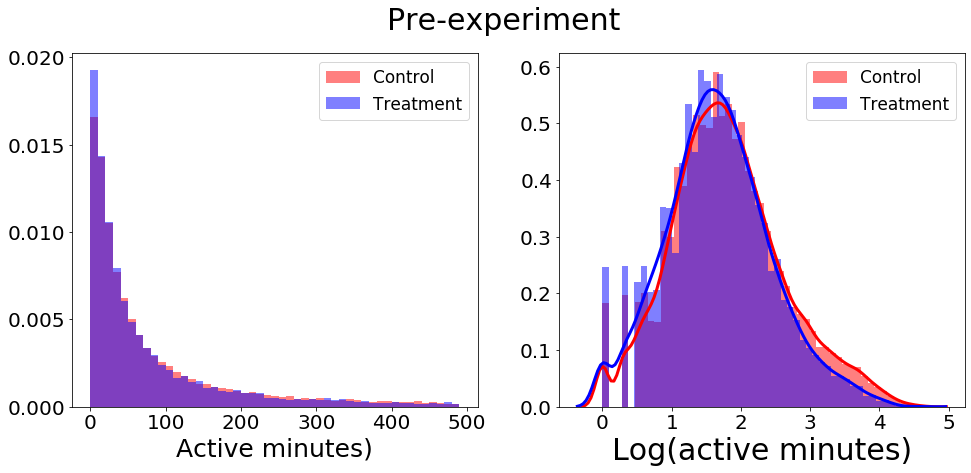

In [386]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 6.5)

sns.distplot(pre_ctrl, bins = np.arange(0, 500, 10), norm_hist=True, kde = False, hist_kws={"alpha": 0.5, "color": "r"}, label= "Control", ax = ax[0])
sns.distplot(pre_treat, bins = np.arange(0, 500, 10), norm_hist=True, kde = False, hist_kws={"alpha": 0.5, "color": "b"}, label= "Treatment", ax = ax[0])

sns.distplot(np.log10(pre_ctrl), hist=True, kde=True, kde_kws={"color": "r", "lw": 3}, hist_kws={"alpha": 0.5, "color": "r"}, label= "Control", ax = ax[1])
sns.distplot(np.log10(pre_treat), hist=True, kde=True, kde_kws={"color": "b", "lw": 3}, hist_kws={"alpha": 0.5, "color": "b"}, label= "Treatment", ax = ax[1])

fig.suptitle('Pre-experiment', fontsize = 30)
ax[0].set_xlabel("Active minutes)",fontsize=25), ax[1].set_xlabel("Log(active minutes)",fontsize=30)
ax[0].tick_params(labelsize=20), ax[1].tick_params(labelsize=20)
ax[0].legend(fontsize='17'), ax[1].legend(fontsize='17');

<font color= #000066>
    
>  Running a t-test on the pre-experiment distributions of total active minutes per user shows they are significantly different (p < 0.001). Visualizing the data in log space reveals that the control distribution has a much heavier tail than the treatment distribution. Later we will see that this is a result of non-random sampling across user type, with "contributor" users making up a much larger fraction of the control group than of the treatment group. 

In [387]:
df_pre = df_pre[df_pre.signup_date > min(df_pre.signup_date)] #remove outliers in sign-up date

#some users signed up during the 180 day pre-experiment period and thus have fewer days of potential activity ('days_alive')
df_pre_ctrl['days_alive'] = (exp_start_date - df_pre_ctrl["signup_date"]).dt.days
df_pre_ctrl.loc[df_pre_ctrl['days_alive'] > (exp_start_date - pre_start_date).days, 'days_alive'] = (exp_start_date - pre_start_date).days

df_pre_treat['days_alive'] = (exp_start_date - df_pre_treat["signup_date"]).dt.days
df_pre_treat.loc[df_pre_treat['days_alive'] > (exp_start_date - pre_start_date).days, 'days_alive'] = (exp_start_date - pre_start_date).days

print('Average number of days \'alive\': control=' + str(round(df_pre_ctrl.groupby('uid').median().days_alive.mean())) + ', treatment=' + str(round(df_pre_treat.groupby('uid').median().days_alive.mean()))) 

Average number of days 'alive': control=147, treatment=142


In [388]:
welch_t_test = sms.CompareMeans.from_data(df_pre_treat.groupby('uid').median().days_alive, df_pre_ctrl.groupby('uid').median().days_alive)
print(welch_t_test.summary(usevar='unequal'))

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1     -4.8332      0.695     -6.953      0.000      -6.196      -3.471



<font color= #000066>
    
>  While the duration of the pre-experiment period is 180 days, some users may sign up at random points during the pre-experiment period. We find that users in the control group have, on average, 147 days of of potential activity in this period out of the maximum of 180 days. Meanwhile, users in the treatment group only have 142 days of being "alive". A t-test indicates the difference is significant. Trying to normalize total minutes by the number of 
days each user was alive in the pre-study period does not work, as it amplifies noise a lot.

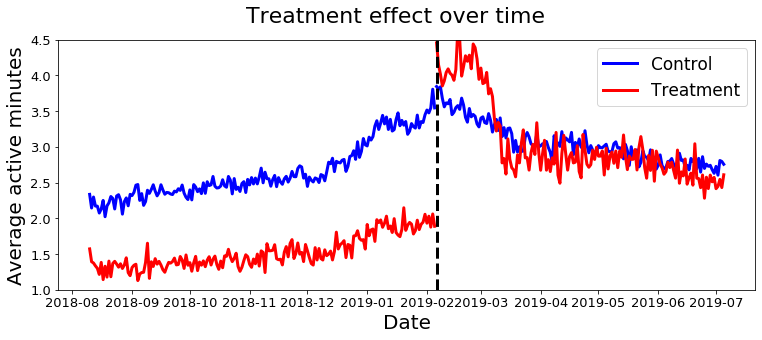

In [389]:
n_exp_treat, n_exp_ctrl = len(exp_treat), len(exp_ctrl)
n_pre_treat, n_pre_ctrl = len(pre_treat), len(pre_ctrl)

fig, ax = plt.subplots(figsize= (12.5, 4.6))
sns.lineplot(x = 'dt', y = 'active_mins', data = (df_pre_ctrl.groupby(['dt'])['active_mins'].sum()/n_pre_ctrl).reset_index(), color = 'blue', linewidth = 3, label= "Control")
sns.lineplot(x = 'dt', y = 'active_mins', data = (df_exp_ctrl.groupby(['dt'])['active_mins'].sum()/n_exp_ctrl).reset_index(), color = 'blue', linewidth = 3)
sns.lineplot(x = 'dt', y = 'active_mins', data = (df_pre_treat.groupby(['dt'])['active_mins'].sum()/n_pre_treat).reset_index(), color = 'red', linewidth = 3, label= "Treatment")
sns.lineplot(x = 'dt', y = 'active_mins', data = (df_exp_treat.groupby(['dt'])['active_mins'].sum()/n_exp_treat).reset_index(), color = 'red', linewidth = 3)
plt.plot([min((df_exp_ctrl.groupby(['dt'])['active_mins'].sum()/n_pre_ctrl).reset_index().dt)]*2, [1, 4.5], color = 'black', linestyle = '--', linewidth = 3)
ax.set_ylim([1, 4.5])

ax.set_xlabel("Date",fontsize=20); ax.set_ylabel("Average active minutes",fontsize=20) 
fig.suptitle('Treatment effect over time', fontsize=22);ax.tick_params(labelsize=13); ax.legend(fontsize='17');

<font color= #000066>
    
>  The plot above shows the average active minutes for the control (blue) and treatment (red) groups, both before and during the experiment, with the two periods separated by the black dashed line. As the t-test suggested, the pre-treatment averages are very different, with the two groups constantly separated by a gap of around one minute. We also see that the treatment produces a large change, which decreases after some time but still remains above the pre-treatment levels. 
>
> Given that the control and treatment group do not seem to be properly randomized, to better asses the effect of the change we will eventually adopt a **difference-in-differences** approach. For now, note that merely based on visuals, it looks like the treatment has a significant effect, as it completely closes and reverses the direction of the gap between average active minutes of the two groups. Let's quantify this by finding the average total active minutes for each of the four (group x period) combinations. 



In [390]:
df_all = pd.concat([df_pre, df_exp], ignore_index=True).sort_values(by = ['uid', 'dt'])

df_all['pre_experiment'] = df_all['dt'] < min(df_exp.dt)
df = df_all.groupby(['variant_number', 'pre_experiment']).sum().reset_index().drop('uid', axis=1).rename(columns = {'active_mins': 'total_active_mins'})
df['users'] = df_all.groupby(['variant_number', 'pre_experiment']).agg({"uid": pd.Series.nunique}).reset_index().uid
df['total_mins_per_person'] = df['total_active_mins'] / df['users']
df


,variant_number,pre_experiment,total_active_mins,users,total_mins_per_person
0,0,False,17148927.0,37425,458.221162
1,0,True,18998587.0,39774,477.663474
2,1,False,4220970.0,9208,458.402476
3,1,True,2725508.0,9921,274.721097


In [391]:
print('Number of users by period: pre-experiment=' + str(len(np.unique(df_pre.uid))) +', experiment=' + str(len(np.unique(df_exp.uid))) +'. Likely indicates churn.')
print('Number of users by (group x period): (pre,ctrl)= ' + str(n_pre_ctrl) + ', (pre,treat)=' + str(n_pre_treat) + ', (exp,ctrl)=' + str(n_exp_ctrl) + ', (exp,treat)=' + str(n_exp_treat))
print('Duration of the two periods: pre-experiment= ' + str((exp_start_date-pre_start_date).days) +' days, experiment= ' + str((max(df_all.dt)-exp_start_date).days))

Number of users by period: pre-experiment=49695, experiment=46633. Likely indicates churn.
Number of users by (group x period): (pre,ctrl)= 39776, (pre,treat)=9921, (exp,ctrl)=37425, (exp,treat)=9208
Duration of the two periods: pre-experiment= 180 days, experiment= 149


<font color= #000066>
    
>  We can see from the table above that the difference in average total minutes per person before and after the treatment is much larger for the treatment group. Note that the number of active users in each (group x period) is different, so we should normalize by the number of users. However, there is still a subtle problem, namely that in pre-experiment period we have participants with different sign up dates and thus different number of days active. In fact, more importantly, the durations of the pre-experiment and experiment periods are different (180 vs 149 days).
>
> The best way to solve all these problems is to restrict the pre-experiment period to the same duration as the experiment period (149 days) as well as restrict to users who are "alive" during the entire duration of both periods. This effectively amounts to using a **cohort** and allows us to apply a t-test on the change in average total active minutes as a function of treatment group.

In [392]:
pre_start_date_new = exp_start_date - (max(df_all.dt)-exp_start_date) #new start date of pre-experiment period
df_all = df_all[(df_all.signup_date<=pre_start_date_new) & (df_all.dt>=pre_start_date_new)]
df = df_all.groupby(['uid', 'variant_number', 'pre_experiment']).sum().reset_index()

df_by_uid = df_all.groupby(['uid']).sum().reset_index().drop(columns = ['variant_number', 'pre_experiment'])
df_by_uid = pd.merge(df_by_uid, df[(df.variant_number == 0) & (df.pre_experiment == True)][['uid', 'active_mins']].rename(columns = {'active_mins': 'pre_ctrl'}), on = 'uid', how='left')
df_by_uid = pd.merge(df_by_uid, df[(df.variant_number == 0) & (df.pre_experiment == False)][['uid', 'active_mins']].rename(columns = {'active_mins': 'exp_ctrl'}), on = 'uid', how='left')
df_by_uid = pd.merge(df_by_uid, df[(df.variant_number == 1) & (df.pre_experiment == True)][['uid', 'active_mins']].rename(columns = {'active_mins': 'pre_treat'}), on = 'uid', how='left')
df_by_uid = pd.merge(df_by_uid, df[(df.variant_number == 1) & (df.pre_experiment == False)][['uid', 'active_mins']].rename(columns = {'active_mins': 'exp_treat'}), on = 'uid', how='left')
df_by_uid['delta_control'] = df_by_uid['exp_ctrl'] - df_by_uid['pre_ctrl']
df_by_uid['delta_treat'] = df_by_uid['exp_treat'] - df_by_uid['pre_treat']

df_by_uid #data grouped by user

,uid,active_mins,pre_ctrl,exp_ctrl,pre_treat,exp_treat,delta_control,delta_treat
0,1,30452.0,15247.0,15205.0,NaN,NaN,-42.0,NaN
1,3,106.0,29.0,77.0,NaN,NaN,48.0,NaN
2,4,95.0,56.0,39.0,NaN,NaN,-17.0,NaN
3,5,195.0,21.0,174.0,NaN,NaN,153.0,NaN
4,6,37.0,11.0,26.0,NaN,NaN,15.0,NaN
...,...,...,...,...,...,...,...,...
36318,49993,258.0,NaN,NaN,129.0,129.0,NaN,0.0
36319,49994,94.0,NaN,NaN,15.0,79.0,NaN,64.0
36320,49996,376.0,NaN,NaN,220.0,156.0,NaN,-64.0
36321,49998,703.0,NaN,NaN,106.0,597.0,NaN,491.0


In [393]:
print('Average change in total minutes after experiment: control= ' + str(round(df_by_uid.delta_control.mean())) + ' min, treatment= ' + str(round(df_by_uid.delta_treat.mean())) +' min')

Average change in total minutes after experiment: control= 8 min, treatment= 234 min


In [394]:
welch_t_test = sms.CompareMeans.from_data(df_by_uid[df_by_uid['delta_treat'].notna()].delta_treat, df_by_uid[df_by_uid['delta_control'].notna()].delta_control)
print(welch_t_test.summary(usevar='unequal'))

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1    226.1708     14.470     15.630      0.000     197.807     254.535


<font color= #000066>
    
>  The t-test confirms that the change in average total minutes is significant, with a confidence interval of **[197.81, 254.54]** and a p-value p<0.001. The treatment effect decreases over time but still remains significant. Based on these findings, my recommendation would be to push the change to production. 

In real life, experiment results can be nuanced. We provide you now additionally table 4 (t4_user_attributes.csv), which might help you analyze the results better. You should think about the context of the experiment and hypothesize why the analysis above could be insufficient. Explore the data and share with us your insights!

* **Given the new tables, were there any issues in treatment assignment? Was the treatment effect different for different covariates?**

* **Based on the new findings, what is your conclusion and what product recommendations would you make to the team?**

Summarize your findings in a brief write-up with up to 200 words, and include one or two plots that best represent your results.



In [395]:
url = 'https://raw.githubusercontent.com/edvinmemet/projects/master/data/ab_testing/t4_user_attributes.csv?token=AF52KYKXCYHZSMEAXUQFO7K5UUNDG'
df_attr = pd.read_csv(url)
df_attr.gender.value_counts()
df_attr.user_type.value_counts()

df_by_uid = pd.merge(df_by_uid, df_attr, on = 'uid', how='left')

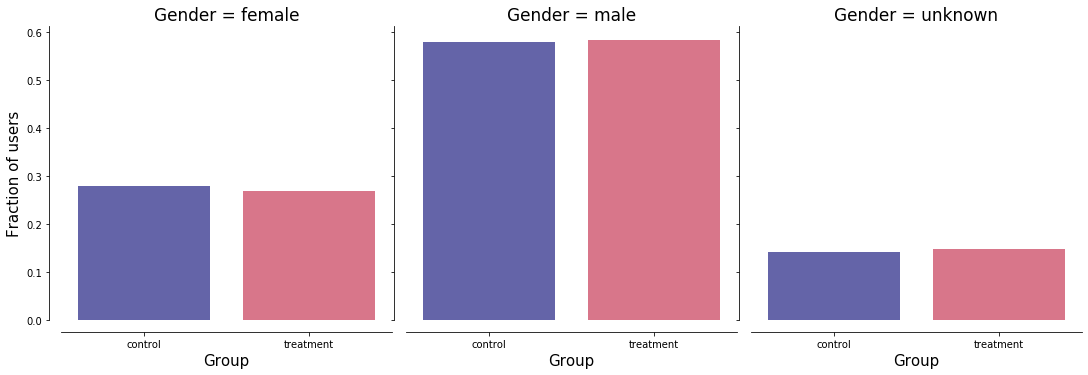

In [396]:
df_gender_count = df_by_uid.groupby(['gender']).count().reset_index().drop(columns = ['uid', 'active_mins', 'delta_control', 'delta_treat', 'user_type', 'exp_ctrl', 'exp_treat'], axis = 1).rename(columns = {'pre_ctrl': 'control', 'pre_treat': 'treatment'}).set_index('gender')
df_gender_fraction = df_gender_count/df_gender_count.sum()
df_gender_fraction = pd.melt(df_gender_fraction.reset_index(), id_vars="gender", var_name=['Group'], value_name="active_mins")
my_pal = {"control": "darkblue", "treatment": "crimson"}
g = sns.catplot(x="Group", y="active_mins", col = 'gender', data=df_gender_fraction, kind = 'bar', height = 5, palette=my_pal, alpha = 0.65)

axes = g.axes.flatten()
axes[0].set_ylabel("Fraction of users", fontsize = 15);
axes[0].set_xlabel("Group", fontsize = 15), axes[1].set_xlabel("Group", fontsize = 15), axes[2].set_xlabel("Group", fontsize = 15);
axes[0].set_title("Gender = female", fontsize = 17), axes[1].set_title("Gender = male", fontsize = 17), axes[2].set_title("Gender = unknown", fontsize = 17);
g.despine(offset=12);

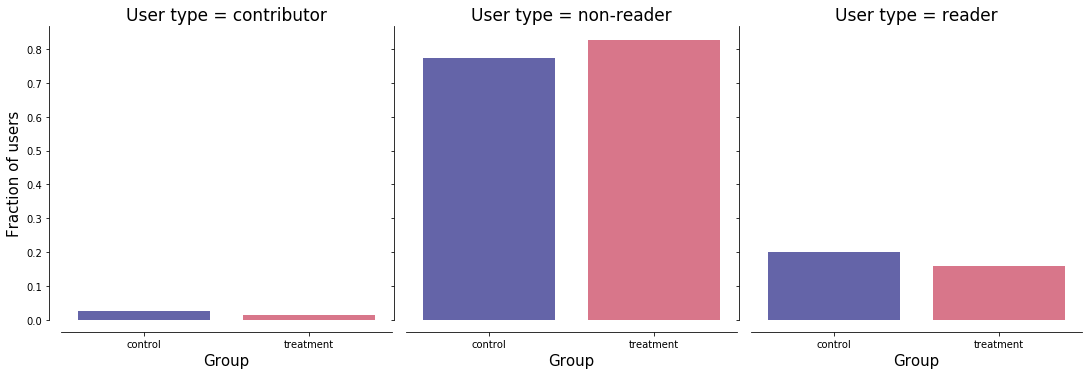

In [397]:
df_user_count = df_by_uid.groupby(['user_type']).count().reset_index().drop(columns = ['uid', 'active_mins', 'delta_control', 'delta_treat', 'gender', 'exp_ctrl', 'exp_treat'], axis = 1).rename(columns = {'pre_ctrl': 'control', 'pre_treat': 'treatment'}).set_index('user_type')
df_user_fraction = df_user_count/df_user_count.sum()
df_user_fraction = pd.melt(df_user_fraction.reset_index(), id_vars="user_type", var_name=['Group'], value_name="active_mins")
my_pal = {"control": "darkblue", "treatment": "crimson"}
g = sns.catplot(x="Group", y="active_mins", col = 'user_type', data=df_user_fraction, kind = 'bar', height = 5, palette=my_pal, alpha = 0.65)

axes = g.axes.flatten()
axes[0].set_ylabel("Fraction of users", fontsize = 15);
axes[0].set_xlabel("Group", fontsize = 15), axes[1].set_xlabel("Group", fontsize = 15), axes[2].set_xlabel("Group", fontsize = 15);
axes[0].set_title("User type = contributor", fontsize = 17), axes[1].set_title("User type = non-reader", fontsize = 17), axes[2].set_title("User type = reader", fontsize = 17);
g.despine(offset=12);

<font color= #000066>
    
>  The assignment of users into treatment and control groups is not random across user type. The assignment across genders is relatively more balanced. Note that new_user types do not appear in the data because they were removed from the analysis in order to make the two treatment groups and periods comparable and amenable to a t-test.

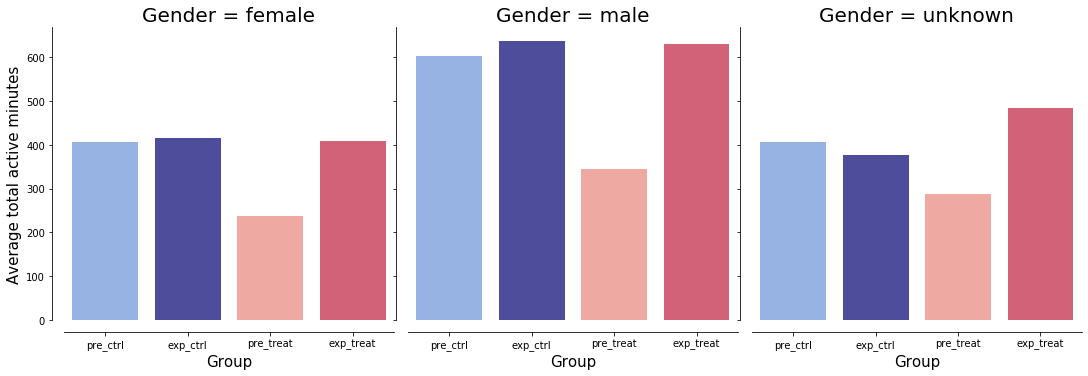

In [398]:
df_gender_mean = pd.melt(df_by_uid.groupby(['gender']).mean().reset_index().drop(columns = ['uid', 'active_mins', 'delta_control', 'delta_treat']), id_vars="gender", var_name=['Group'], value_name="active_mins")
my_pal = {"pre_ctrl": "cornflowerblue", "exp_ctrl": "darkblue", "pre_treat":"salmon", "exp_treat":"crimson"}
g = sns.catplot(x="Group", y="active_mins", col = 'gender', data=df_gender_mean, kind = 'bar', height = 5, palette=my_pal, alpha = 0.75)
                                                                                                                                                                                                                                                                                             
axes = g.axes.flatten()
axes[0].set_ylabel("Average total active minutes", fontsize = 15);
axes[0].set_xlabel("Group", fontsize = 15), axes[1].set_xlabel("Group", fontsize = 15), axes[2].set_xlabel("Group", fontsize = 15);
axes[0].set_title("Gender = female", fontsize = 20), axes[1].set_title("Gender = male", fontsize = 20), axes[2].set_title("Gender = unknown", fontsize = 20);
g.despine(offset=12);

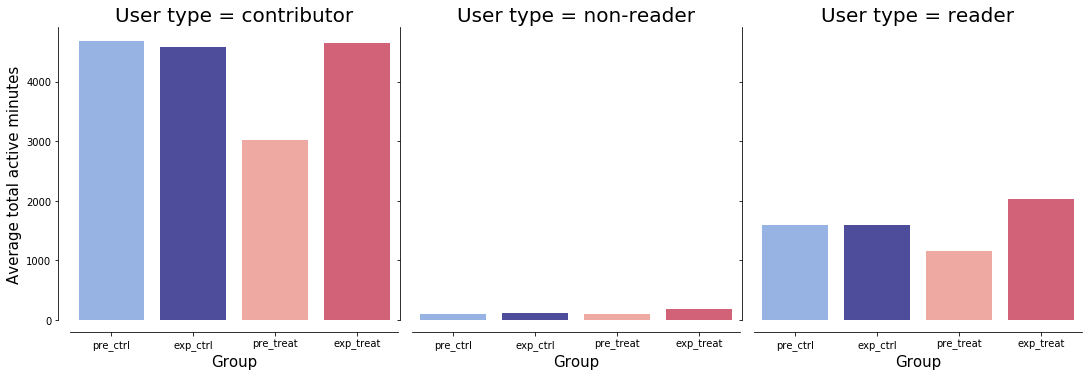

In [399]:
df_user_mean = pd.melt(df_by_uid.groupby(['user_type']).mean().reset_index().drop(columns = ['uid', 'active_mins', 'delta_control', 'delta_treat']), id_vars="user_type", var_name=['Group'], value_name="active_mins")
my_pal = {"pre_ctrl": "cornflowerblue", "exp_ctrl": "darkblue", "pre_treat":"salmon", "exp_treat":"crimson"}
g = sns.catplot(x="Group", y="active_mins", col = 'user_type', data=df_user_mean, kind = 'bar', height = 5, palette=my_pal, alpha = 0.75)
                                                                                                                                                                                                                                                                                             
axes = g.axes.flatten()
axes[0].set_ylabel("Average total active minutes", fontsize = 15);
axes[0].set_xlabel("Group", fontsize = 15), axes[1].set_xlabel("Group", fontsize = 15), axes[2].set_xlabel("Group", fontsize = 15);
axes[0].set_title("User type = contributor", fontsize = 20), axes[1].set_title("User type = non-reader", fontsize = 20), axes[2].set_title("User type = reader", fontsize = 20);
g.despine(offset=12);

<font color= #000066>
    
>  From the plots above we can see, for example, that males respond more strongly to the treatment than females. However, difference across user types are much more striking, in both baseline values and treatment response. For instance, contributors spend about 50 times more minutes on the site than non-readers. Moreover, as noted above, the assignment of treatment across user types is flawed, with contributors making up 2.7% of the control group but only 1.6 % of the treatment group. This explains why in the pre-experiment period the control and treatment groups are significantly different in total active minutes. 
>
> In light of these new finding, my conclusion and product recommendation remain the same since the t-test analysis on the change in total active minutes resolved any issues in treatment assignment by restricting the analysis to the same set of users in both periods (i.e. using a **cohort**). Despite the shortcomings in treatment assignment, our careful analysis makes it clear that the treatment has a significant effect. Besides the issue of statistical significance, the decision to implement a change is also a function of practical significance, i.e. an effect can be statistically significant yet too small to justify allocating resources. However, in this case the effect seems to be very strong, so my recommendation would be to **push the change to production**. 

**Aside from this new UI design, our mobile team is looking into improving retention of app users. In other words, we hope that users who have started using the app come back often to continue using our app. Assuming you have access to all our data, what data analyses would you do to shape product strategies in this area?**

List 3 ideas, please a) be as specific as possible - clearly define the metrics you want to look at, such that following your prescription, a data scientist on the team can produce the same numbers; b) explain how you will generate insights from the data. As an example of a specific analysis idea (for a different analysis purpose): "I will look at the total number of answers written in the last month, breaking down by country. If the data shows X, this means Y and I would recommend Z as our strategy."

<font color= #000066>
    
>  The first step would be to determine which factors are important for retention, or equivalently, which factors predict churn. For example, the top factor affecting churn could be, say, age/demographic related or it could be engagement related. If churn risk is primarily age/demographic related, we may want to investigate what is different about the way different categories interact with the platform (e.g. clustering on user activity metrics). If churn risk is primarily related to engagement, we can also do a clustering analysis on topics of interest to identify whether specific topics are predictive of churn (for example, perhaps there is relatively little content in specific topics). In case engagement is a major factor in churn, we can also look into data on user engagement with email updates/app notifications (for users who are signed up to receive emails/notifications). If the data shows this is an important factor, we could use A/B testing to fine-tune email marketing strategy and content. 
>
> It might be that some factors affecting retention are not readily quantifiable, such as perceived quality of content, or perceived fraction of low-quality questions/answers. We may still get some idea of such perceptions from user activity such as downvotes/upvotes, reporting, sharing, or commenting. Getting feedback directly from users is also an option, through focus groups, user surveys, etc. Another way to gather insights on user perception would be to analyze data from sources such as Twitter. 
>
> We can also increase churn by focusing our marketing/user acquisition efforts where it matters most. For example, we can select a group of very loyal customers and perform a clustering analysis to determine which segments of users are most likely to have high retention. 